In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math
import gc
from pysr import pysr

import read_orbits
from solar_system_names import *
from ml_model import *

Global Constants

In [2]:
# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (0.5/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MSUN*DAY**2

Training variables

In [3]:
# Training variables
patience = 5
d_patience = 0
noise_level = 0.01
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
#total_time_traj = 40 #Years
#num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 520000 #An orbit for saturn is 129110 steps
num_time_steps_sr = 500
#num_batches = 13000
batch_size_tr = 32#num_time_steps_tr//num_batches
num_batches = num_time_steps_tr//batch_size_tr

Read the data

In [4]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

In [5]:
nplanets = 8 # Number of planets (not counting the sun)
data, masses, names = read_orbits.main(nplanets = nplanets, frame='b', use_moons = True, 
                                       path='/Users/Pablo/Dropbox/data/orbits/7parts/full/')
nplanets = len(data[0])
nedges = nplanets*(nplanets-1)//2
batch_size_tr = num_time_steps_tr//num_batches

# Get the acceleration
A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A/delta_time 
data = data[:-1]

# For debugging, reduce size of validation data. Really speeds things up!
nval = 10000
data = data[:(num_time_steps_tr + nval)]

masses/=MSUN#/1000000

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

num_time_steps_tr = 130000
data_tr = data_tr[:num_time_steps_tr]

Reading data in Solar System barycenter reference frame
Reading data for mercury
Reading data for venus
Reading data for earth
Reading data for moon
Reading data for mars
Reading data for jupiter
Reading data for io
Reading data for europa
Reading data for ganymede
Reading data for callisto
Reading data for saturn
Reading data for mimas
Reading data for enceladus
Reading data for tethys
Reading data for dione
Reading data for rhea
Reading data for titan
Reading data for hyperion
Reading data for iapetus
Reading data for phoebe
Reading data for uranus
Reading data for ariel
Reading data for umbriel
Reading data for titania
Reading data for oberon
Reading data for miranda
Reading data for neptune
Reading data for triton
Reading data for nereid
Reading data for proteus
Finished reading data
The data array contains 31 bodies.


In [6]:
D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
data_norm = np.empty([len(data_tr), nedges, 3])
F_val = np.empty([len(data_val), nedges, 3])
k=0
names_edges = []
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr_np[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val_np[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            F_val[:,k,:] = force_newton(d_val, masses[i], masses[j]) #cartesian_to_spherical_coordinates(d_val)
            names_edges.append(names[j] + ' - ' + names[i])
            #data_norm[:,k,0] = np.log10(masses[i])
            #data_norm[:,k,1] = np.log10(masses[j])
            #data_norm[:,k,2] = np.log10(G)
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 
#A_norm = 1.

D_tr_flat = np.reshape(D_tr_np, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val_np,[1, num_time_steps_val*nedges, 3])

#A_tr_sph = cartesian_to_spherical_coordinates(A_tr/A_norm)
#A_val_sph = cartesian_to_spherical_coordinates(A_val/A_norm)
A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")

#maxA = tf.reduce_max(A_tr_sph, axis = 0)
#minA = tf.reduce_min(A_tr_sph, axis = 0)
#A_tr_sph_norm = 2*(A_tr_sph - minA)/(maxA-minA)-1
#A_val_sph_norm = 2*(A_val_sph - minA)/(maxA-minA)-1

D_tr_batches = tf.split(D_tr,  num_batches)
A_tr_batches = tf.split(A_tr,  num_batches)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

norm_layer = Normalize_gn(cartesian_to_spherical_coordinates(D_tr))

In [7]:
A_tr = None
A_val = None
D_tr = None
#D_val = None
A_tr_flat = None
A_val_flat = None
D_tr_flat = None
#D_val_flat = None
A_tr_batches = None
D_tr_batches = None
data = None
data_tr = None
gc.collect()

20

In [8]:
checkpoint_filepath = './saved_models/final_128_v2'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            verbose = 1,
                                            patience=20,
                                            #baseline = 0.1,
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)
model = LearnForces(nplanets, senders, receivers, norm_layer, noise_level = noise_level)

#model.compile(run_eagerly=True)
model.compile()

In [9]:
model.fit(train_ds, 
          epochs = 1000, 
          verbose=2,
          #callbacks=[early_stopping], 
          callbacks=[early_stopping, checkpoint], 
          validation_data=test_ds
         )

Epoch 1/1000
16250/16250 - 259s - loss: 1457166.1250 - val_loss: 29.2973
Epoch 2/1000
16250/16250 - 199s - loss: 2.3588 - val_loss: 1.0386
Epoch 3/1000
16250/16250 - 184s - loss: 0.3640 - val_loss: 0.1276
Epoch 4/1000
16250/16250 - 196s - loss: 0.0984 - val_loss: 0.0818
Epoch 5/1000
16250/16250 - 188s - loss: 0.0914 - val_loss: 0.0806
Epoch 6/1000
16250/16250 - 180s - loss: 0.0875 - val_loss: 0.0745
Epoch 7/1000
16250/16250 - 185s - loss: 0.0850 - val_loss: 0.0746
Epoch 8/1000
16250/16250 - 193s - loss: 0.0840 - val_loss: 0.0716
Epoch 9/1000
16250/16250 - 184s - loss: 0.0824 - val_loss: 0.1044
Epoch 10/1000
16250/16250 - 185s - loss: 0.0803 - val_loss: 0.0777
Epoch 11/1000
16250/16250 - 185s - loss: 0.0795 - val_loss: 0.0730
Epoch 12/1000
16250/16250 - 181s - loss: 0.0787 - val_loss: 0.0503
Epoch 13/1000
16250/16250 - 197s - loss: 0.0782 - val_loss: 0.0804
Epoch 14/1000
16250/16250 - 186s - loss: 0.0776 - val_loss: 0.0528
Epoch 15/1000
16250/16250 - 207s - loss: 0.0777 - val_loss: 0.07

Epoch 123/1000
16250/16250 - 191s - loss: 0.0544 - val_loss: 0.0548
Epoch 124/1000
16250/16250 - 186s - loss: 0.0541 - val_loss: 0.0532
Epoch 125/1000
16250/16250 - 210s - loss: 0.0541 - val_loss: 0.0431
Epoch 126/1000
16250/16250 - 263s - loss: 0.0543 - val_loss: 0.0438
Epoch 127/1000
16250/16250 - 261s - loss: 0.0544 - val_loss: 0.0472
Epoch 128/1000
16250/16250 - 260s - loss: 0.0544 - val_loss: 0.0552
Epoch 129/1000
16250/16250 - 248s - loss: 0.0542 - val_loss: 0.0518
Epoch 130/1000
16250/16250 - 248s - loss: 0.0541 - val_loss: 0.0395
Epoch 131/1000
16250/16250 - 223s - loss: 0.0545 - val_loss: 0.0380
Epoch 132/1000
16250/16250 - 132s - loss: 0.0542 - val_loss: 0.0382
Epoch 133/1000
16250/16250 - 134s - loss: 0.0543 - val_loss: 0.0390
Epoch 134/1000
16250/16250 - 134s - loss: 0.0543 - val_loss: 0.0381
Epoch 135/1000
16250/16250 - 132s - loss: 0.0540 - val_loss: 0.0499
Epoch 136/1000
16250/16250 - 126s - loss: 0.0542 - val_loss: 0.0409
Epoch 137/1000
16250/16250 - 128s - loss: 0.0540

In [10]:
model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

1/1 [==============================] - 4s 4s/step - loss: 0.0324


0.032361485064029694

In [11]:
j=0
learned_masses = model.logm_planets.numpy() - model.logm_planets.numpy()[j]
for i in range(nplanets):
    print(f'{names[i]}, {np.log10(masses[i]/masses[j]):.2f}, {learned_masses[i]:.2f}, {abs(np.log10(masses[i]/masses[j]) -learned_masses[i])/abs(np.log10(masses[i])):.2f}')


sun, 0.00, 0.00, nan
mercury, -6.78, -10.05, 0.48
venus, -5.61, -9.60, 0.71
earth, -5.52, -5.50, 0.00
moon, -7.43, -8.29, 0.12
mars, -6.49, -8.99, 0.38
jupiter, -3.02, -3.03, 0.00
io, -7.35, -7.30, 0.01
europa, -7.62, -7.72, 0.01
ganymede, -7.13, -7.32, 0.03
callisto, -7.27, -7.75, 0.07
saturn, -3.54, -3.55, 0.00
mimas, -10.72, -10.40, 0.03
enceladus, -10.27, -10.15, 0.01
tethys, -9.51, -9.98, 0.05
dione, -9.26, -9.41, 0.02
rhea, -8.94, -9.36, 0.05
titan, -7.17, -7.25, 0.01
hyperion, -11.55, -8.54, 0.26
iapetus, -9.04, -7.66, 0.15
phoebe, -11.38, -6.42, 0.44
uranus, -4.36, -4.35, 0.00
ariel, -9.20, -9.23, 0.00
umbriel, -9.19, -9.14, 0.01
titania, -8.77, -8.75, 0.00
oberon, -8.81, -8.77, 0.00
miranda, -10.49, -10.51, 0.00
neptune, -4.29, -4.29, 0.00
triton, -7.97, -7.97, 0.00
nereid, -10.81, -7.52, 0.30
proteus, -10.66, -10.60, 0.01


/Users/Pablo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


# Evaluate on validation data

In [12]:
ap ,fp = model(D_val_flat[0], extract = True)

In [13]:
F_val_new = np.empty([len(data_val), nedges, 3])
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            F_val_new[:,k,:] = force_newton(d_val, 10**learned_masses[i], 10**learned_masses[j]) #cartesian_to_spherical_coordinates(d_val)
            k+=1

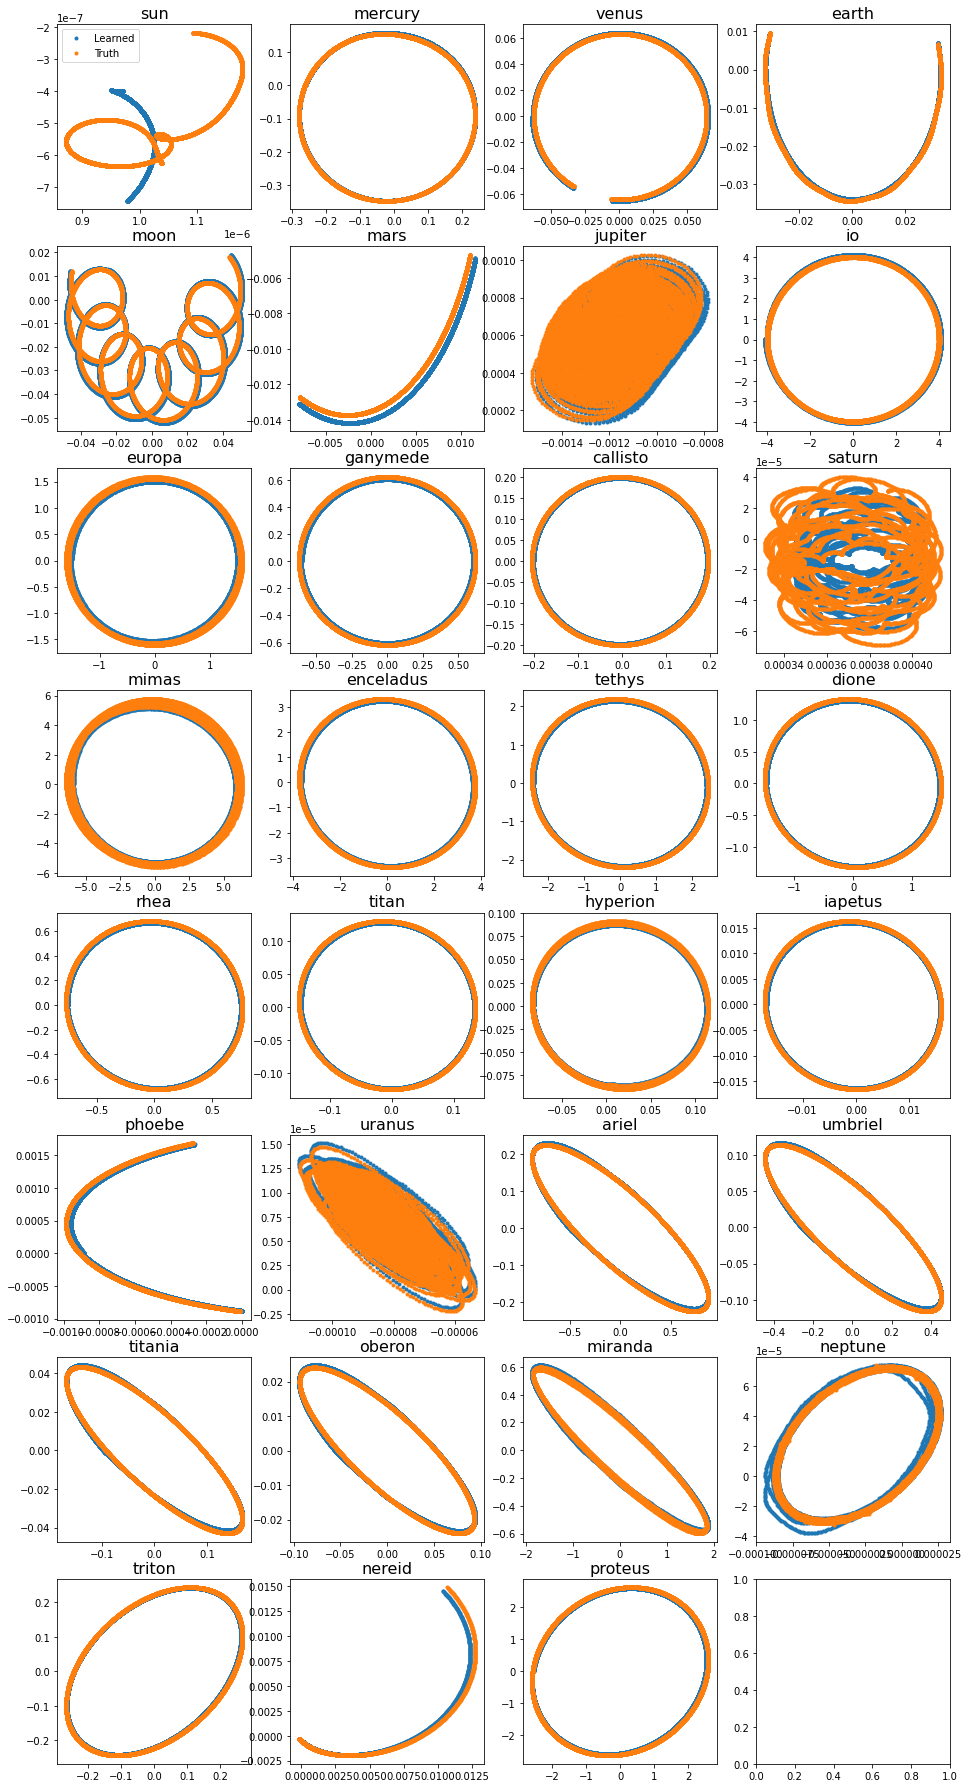

In [14]:
nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.', label = 'Learned')
    ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.', label = 'Truth')

ax[0,0].legend()
#plt.savefig('/Users/Pablo/Desktop/full_learnedmasses.png')

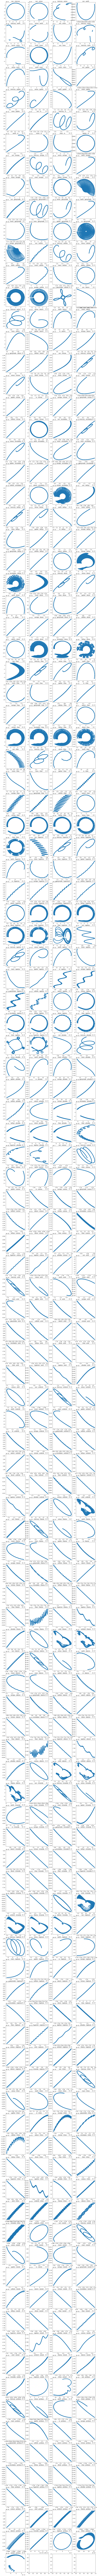

In [15]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    #ax[i//4, i%4].plot(F_val_new[:,i,0], F_val_new[:,i,1], '.')
    #ax[i//4, i%4].plot(fp[:,i,0]*n1/n2, fp[:,i,1]*n1/n2, '.')
    ax[i//4, i%4].plot(fp[:,i,0], fp[:,i,1], '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

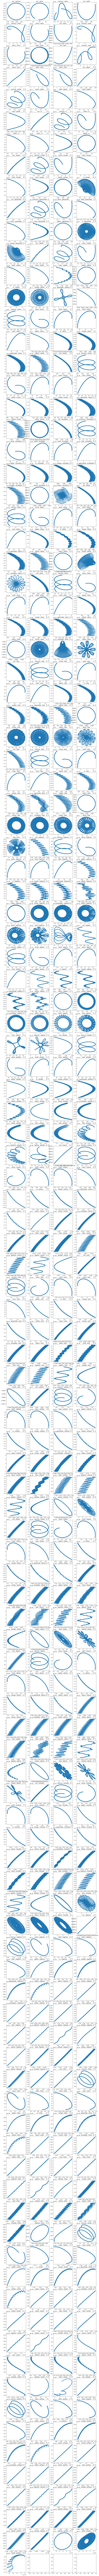

In [16]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    ax[i//4, i%4].plot(F_val[:,i,0]*1e8, F_val[:,i,1]*1e8, '.')
    #ax[i//4, i%4].plot(fp[:,i,0]*n1/n2, fp[:,i,1]*n1/n2, '.')
    #ax[i//4, i%4].plot(fp[:,i,0], fp[:,i,1], '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

In [17]:
'''
dv = tf.reshape(D_val, [-1, nedges, 3])
dv, fp = rotate_data(dv, fp)
F_pred_sr = np.empty([num_time_steps_sr, nedges, 3])
D_val_sr = np.empty([num_time_steps_sr, nedges, 3])
for i in range(num_time_steps_sr):
    Dv_temp, Fp_temp = rotate_data(dv[i], fp[i])
    F_pred_sr[i] = Fp_temp
    D_val_sr[i] = Dv_temp
'''

'\ndv = tf.reshape(D_val, [-1, nedges, 3])\ndv, fp = rotate_data(dv, fp)\nF_pred_sr = np.empty([num_time_steps_sr, nedges, 3])\nD_val_sr = np.empty([num_time_steps_sr, nedges, 3])\nfor i in range(num_time_steps_sr):\n    Dv_temp, Fp_temp = rotate_data(dv[i], fp[i])\n    F_pred_sr[i] = Fp_temp\n    D_val_sr[i] = Dv_temp\n'

In [18]:
X = np.zeros([nval, nedges,9])
X[:,:,2:5] = D_val_np
X[:,:,5] = np.linalg.norm(D_val_np, axis = -1)
X[:,:,6:] = fp
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            X[:,k,0] = 10**(learned_masses[i])
            X[:,k,1] = 10**(learned_masses[j])
            #print(fp[0,k,0], X[0,k,0]*X[0,k,1]*X[0,k,2]/X[0,k,5]**3.)
            k+=1 
            
X[:,:,2:5], X[:,:,6:] = rotate_data(X[:,:,2:5], X[:,:,6:], uniform = False)

X = np.reshape(X, [nval*nedges,9])
X = X[np.linalg.norm(X[:,6:], axis = -1)>-1e10]
np.random.shuffle(X)

In [19]:
y = X[:,6] #F_x
#X[:, [0, 1]] = np.exp(X[:, [0, 1]])/1e23 #re-scale to prevent precision issues, since pysr uses 32-bit floats
y /= np.mean(abs(y))                                 #same as above

equations = pysr(X[:5000,:6], y[:5000],
     #equation_file = '/Users/Pablo/Desktop/equation_files/equation_file.csv',
     niterations=10, populations=50,
     parsimony=0.0, procs=4, maxsize=20,
     variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
     unary_operators=['square', 'cube'],
     binary_operators=["mult", 'div'],
     #constraints={'pow': (3, 3)}
)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpy9jtjhej/runfile.jl
Started!

Cycles per second: 2.300e+05
Progress: 50 / 500 total iterations (10.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
12          2.303e+01  8.145e-01  mult(mult(div(mult(square(m0), x), div(5.8110863e-9, m1)), m1), 0.9512404)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(cube(cube(0.13092345)), 0.51416254), square(m1))), 0.9512404)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(mult(cube(cube(0.13092345)), 0.51416254), m1)),


Cycles per second: 4.290e+04
Progress: 65 / 500 total iterations (13.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851


Cycles per second: 1.360e+04
Progress: 90 / 500 total iterations (18.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851


Cycles per second: 1.290e+04
Progress: 99 / 500 total iterations (19.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851


Cycles per second: 1.870e+04
Progress: 134 / 500 total iterations (26.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 2.240e+04
Progress: 152 / 500 total iterations (30.400%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.350e+04
Progress: 164 / 500 total iterations (32.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.020e+04
Progress: 181 / 500 total iterations (36.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 9.030e+03
Progress: 196 / 500 total iterations (39.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 8.900e+03
Progress: 206 / 500 total iterations (41.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 6.550e+03
Progress: 215 / 500 total iterations (43.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 4.940e+03
Progress: 223 / 500 total iterations (44.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585

19          4.332e-02  3.138e+00  mult(m0, div(div(x, mult(mult(cube(div(div(0.030859588, m1), 2.6174335)), m1), cube(mult(r, 0.31553873)))), m1))


Cycles per second: 8.080e+03
Progress: 236 / 500 total iterations (47.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mul


Cycles per second: 1.030e+04
Progress: 247 / 500 total iterations (49.400%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585

19          4.332e-02  3.138e+00  mult(m0, div(div(x, mult(mult(cube(div(div(0.030859588, m1), 2.6174335)), m1), cube(mult(r, 0.31553873)))), m1))
21          4.332e-02  5.335e-06  mult(m0, div(div(x, mult(mult(cube(div(div(0.0460529, mult(m1, 1.1819942)), 2.8014731)), m1), cube(mult(r, 0.26749253)))), m1))


Cycles per second: 1.050e+04
Progress: 259 / 500 total iterations (51.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m


Cycles per second: 2.390e+04
Progress: 293 / 500 total iterations (58.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 9.480e+03
Progress: 309 / 500 total iterations (61.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.240e+04
Progress: 326 / 500 total iterations (65.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.310e+04
Progress: 338 / 500 total iterations (67.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.240e+04
Progress: 353 / 500 total iterations (70.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.110e+04
Progress: 363 / 500 total iterations (72.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 7.530e+03
Progress: 373 / 500 total iterations (74.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.240e+04
Progress: 394 / 500 total iterations (78.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 7.600e+03
Progress: 403 / 500 total iterations (80.600%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 9.890e+03
Progress: 416 / 500 total iterations (83.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.270e+04
Progress: 430 / 500 total iterations (86.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.150e+04
Progress: 442 / 500 total iterations (88.400%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 8.940e+03
Progress: 451 / 500 total iterations (90.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 7.820e+03
Progress: 460 / 500 total iterations (92.000%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 9.930e+03
Progress: 472 / 500 total iterations (94.400%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 1.030e+04
Progress: 484 / 500 total iterations (96.800%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585


Cycles per second: 8.450e+03
Progress: 496 / 500 total iterations (99.200%)
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           3.563e+02  0.000e+00  -0.444733
1           3.573e+02  -2.825e-03  m1
3           3.543e+02  4.169e-03  div(m1, -0.17222656)
5           3.529e+02  2.006e-03  div(mult(x, m1), z)
7           3.399e+02  1.876e-02  div(div(x, r), div(0.03267313, m1))
9           2.652e+02  1.241e-01  div(div(mult(div(m0, -1.5067435e-5), m1), z), 0.98115325)
11          2.303e+01  1.222e+00  mult(div(mult(square(m0), x), div(5.993453e-9, cube(m1))), 0.97976124)
13          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.0375851))), 0.9705588)
15          2.303e+01  -0.000e+00  mult(div(mult(square(m0), x), div(mult(m1, 6.1602425e-9), mult(cube(m1), 1.0375851))), 0.9705588)
16          2.303e+01  -0.000e+00  mult(mult(div(mult(square(m0), x), div(6.1602425e-9, mult(cube(m1), 1.037585

In [20]:
from pysr import best

In [21]:
best(equations)

19422207.0337081*m0*m1*x/r**3

# TO DO:

### To finish the project
- Nearly working
- Try without spherical?

### To clean the model
- Include some kind of training progress bar
- Improve plotting

### Problems to fix
- Just the Symbolic regression!

# Requirements
- The graphnets tensorflow 2 installation
- pysr
- matplotlib